<br>

<h1 style="text-align:center;">Customer Service LLM</h1>

<br>

## Introduction

---

In this project, we aim to fine-tune Llama 3 specifically for customer service applications.

In [1]:
!pip install --upgrade datasets accelerate bitsandbytes transformers peft huggingface_hub trl torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 703.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 69.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 87.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━

In [2]:
# Import the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import transformers
import torch
from huggingface_hub import login
import peft
import trl

# Import the local modules
import env_var

In [3]:
# Setup environment variables
env_var.set_envitonment_variables()

In [4]:
# Set matplotlub style
plt.style.use('ggplot')

In [5]:
# Model name
model_name = "meta-llama/Meta-Llama-3-8B"

In [7]:
# Login to huggingface
login(token = os.environ['HF_TOKEN'])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


<br>

## Load Dataset

---

Source: https://huggingface.co/datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset

In [7]:
# Load the dataset
ds = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

# Get train split only as the rest is unavailable
ds = ds["train"]

ds

Dataset({
    features: ['flags', 'instruction', 'category', 'intent', 'response'],
    num_rows: 26872
})

<br>

## EDA

---

Let's delve into and scrutinize the dataset.

In [8]:
# Convert to dataframe
df = pd.DataFrame(ds)

df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [9]:
# Number of rows and columns
df.shape

(26872, 5)

Total number of unique flags: 394


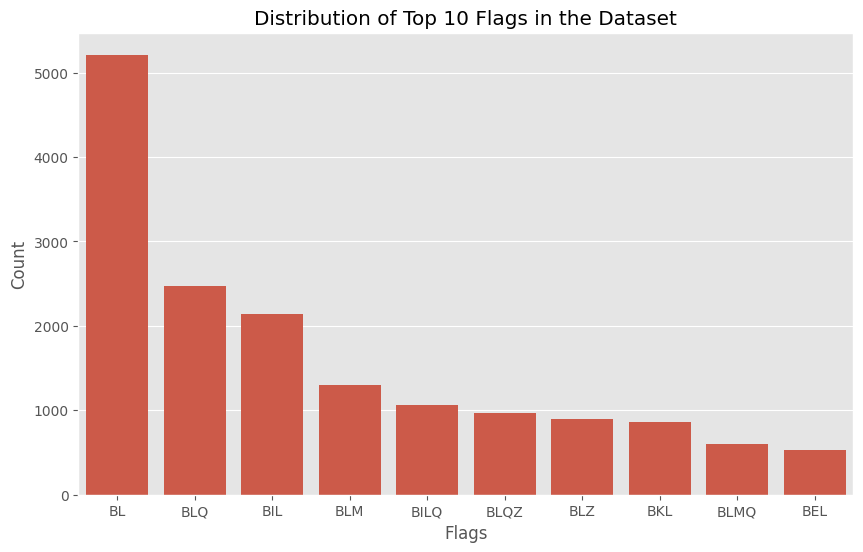

In [10]:
# Distribution of flags

# Print the total number of unique flags
print(f"Total number of unique flags: {len(df['flags'].unique())}")

# Get the distribution of flags and limit to top N, for example, top 10
top_n = 10
flags_distribution = df['flags'].value_counts().head(top_n)

# Creating the plot for the top N flags
plt.figure(figsize=(10, 6))
sns.barplot(x=flags_distribution.index, y=flags_distribution.values)

# Adding plot labels and title for clarity
plt.xlabel('Flags')
plt.ylabel('Count')
plt.title(f'Distribution of Top {top_n} Flags in the Dataset')

# Display the plot
plt.xticks(rotation=0)  # Rotate labels to prevent overlap
plt.show()

Total number of unique categories: 11


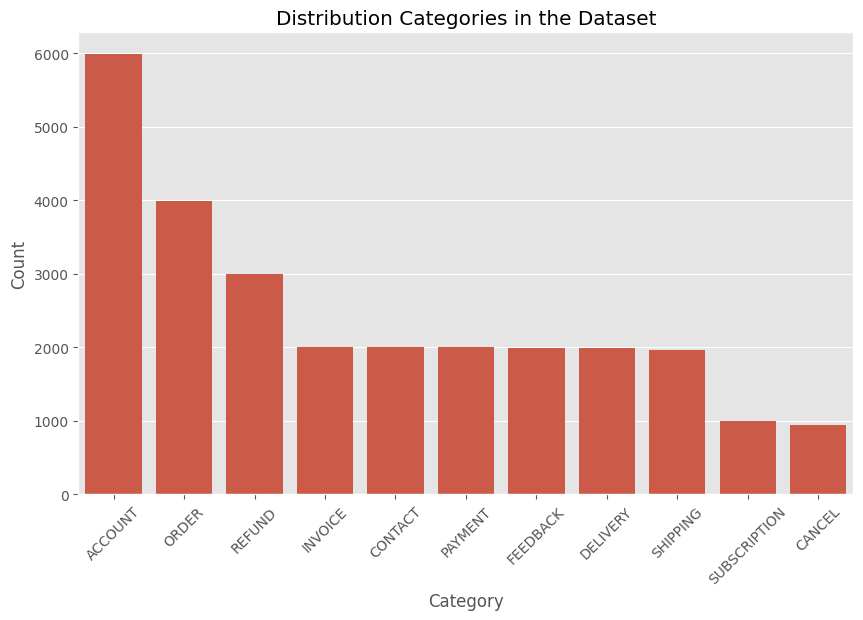

In [11]:
# Distribution of categories

# Print the total number of unique flags
print(f"Total number of unique categories: {len(df['category'].unique())}")

# Distribution of categories
flags_distribution = df['category'].value_counts()

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=flags_distribution.index, y=flags_distribution.values)

# Adding plot labels and title for clarity
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Distribution Categories in the Dataset')

# Display the plot
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.show()

Total number of unique intents: 27


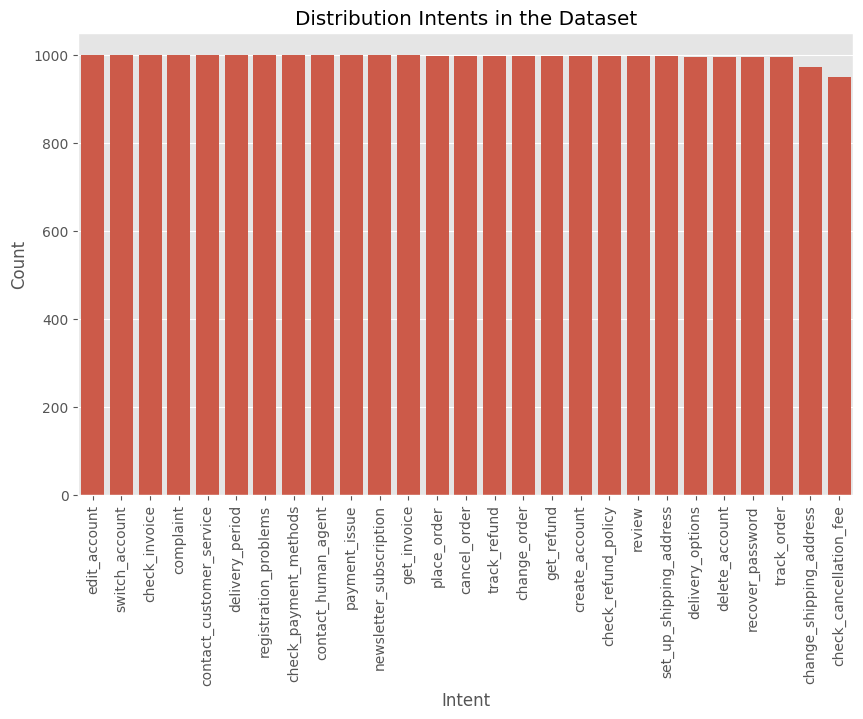

In [12]:
# Distribution of intents

# Print the total number of unique intents
print(f"Total number of unique intents: {len(df['intent'].unique())}")

# Distribution of intents
flags_distribution = df['intent'].value_counts()

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=flags_distribution.index, y=flags_distribution.values)

# Adding plot labels and title for clarity
plt.xlabel('Intent')
plt.ylabel('Count')
plt.title(f'Distribution Intents in the Dataset')

# Display the plot
plt.xticks(rotation=90)  # Rotate labels to prevent overlap
plt.show()

<br>

## Data Prepration and Preprocessing

---

In this section, we will ready the dataset for fine-tuning.

In [14]:
# Initialize the tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# Set the special tokens
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_bos_token = True
tokenizer.add_eos_token = True

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
# Test the tokenizer
tokens = tokenizer(["Name three primary colors."], return_tensors="pt")
tokens

{'input_ids': tensor([[128000,    678,   2380,   6156,   8146,     13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [16]:
# Format the chat template
def format_chat_template(row):

    # Get contents
    user_content = f"Flags: {row['flags']}, Category: {row['category']}, Intent: {row['intent']}, Instruction: {row['instruction']}"
    assistant_content = row['response']

    # Row in json format
    row_json = [{"role": "user", "content": user_content},
               {"role": "support", "content": assistant_content}]

    # Add the whole text
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)

    return row

# Apply the function to the dataset
ds = ds.map(format_chat_template, num_proc=4,)

ds

Map (num_proc=4):   0%|          | 0/26872 [00:00<?, ? examples/s]

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default clas

Dataset({
    features: ['flags', 'instruction', 'category', 'intent', 'response', 'text'],
    num_rows: 26872
})

In [17]:
# Shuffle + Sample
ds = ds.shuffle(seed=1).select(range(500))

# Split the dataset
ds = ds.train_test_split(test_size=0.1)

ds

DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response', 'text'],
        num_rows: 450
    })
    test: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response', 'text'],
        num_rows: 50
    })
})

<br>

## Fine-Tune Llama 3

---

In this segment, we'll be fine-tuning the Llama 3 model specifically for customer service applications using our dataset.

In [18]:
# Configure the quantization (to save memory)
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= True,
)

bnb_config

BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

In [19]:
# Load model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager"
)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [20]:
# Setup chat format
model, tokenizer = trl.setup_chat_format(model, tokenizer)

In [21]:
# Test the model
def generate_text(prompt, max_length=200):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(outputs[0])
    return generated_text

prompt = "How can i cancel the order for {{Order Number}}"
generated_text = generate_text(prompt)
print(generated_text)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
2024-07-01 11:37:03.426592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 11:37:03.426716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 11:37:03.591911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515]

<|begin_of_text|>How can i cancel the order for {{Order Number}}?
How can i cancel the order for {{Order Number}}?
If you want to cancel an order, you need to contact us within 24 hours after you made the order. You can contact us by phone or email.<|end_of_text|><|begin_of_text|>://We will cancel the order and refund you the full payment. Please note that you cannot cancel the order if the order is in processing or shipped.
How can i cancel the order for {{Order Number}}?
If you want to cancel an order, you need to contact us within 24 hours after you made the order. You can contact us by phone or email. We will cancel the order and refund you the full payment. Please note that you cannot cancel the order if the order is in processing or shipped.
How can i cancel the order for {{Order Number}}?
If you want to cancel an order, you need to contact us within 24 hours after you made the order. You can contact


In [22]:
# LoRA config
peft_config = peft.LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Attach the adapter layer with a few parameters to make the process faster and more memory efficient
model = peft.get_peft_model(model, peft_config)

In [23]:
model_dir = "./llama-3-8b-chat-customer-service/dir"

In [24]:
training_arguments = transformers.TrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
##### 
trainer = trl.SFTTrainer(
    model=model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    peft_config=peft_config,
    max_seq_length=512,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1961: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [26]:
# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Step,Training Loss,Validation Loss
45,0.846200,1.024079
90,0.775900,0.898343
135,0.921200,0.841862
180,0.746200,0.787333
225,0.736500,0.751486


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=225, training_loss=0.939769541422526, metrics={'train_runtime': 480.4284, 'train_samples_per_second': 0.937, 'train_steps_per_second': 0.468, 'total_flos': 3245896232558592.0, 'train_loss': 0.939769541422526, 'epoch': 1.0})

In [27]:
# Save the model
trainer.model.save_pretrained("llama-3-8b-chat-customer-service")

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [28]:
# Push to hugging face hub
trainer.model.push_to_hub("llama-3-8b-chat-customer-service", use_temp_dir=False)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/soheill/llama-3-8b-chat-customer-service/commit/6a2d72e2ed4d671aec74479f5d26ca0325316fa2', commit_message='Upload model', commit_description='', oid='6a2d72e2ed4d671aec74479f5d26ca0325316fa2', pr_url=None, pr_revision=None, pr_num=None)

<br>

## Generation

---

In this part, we will generate responses based on the given prompt.

In [31]:
# Function for generating responses
def generate_support(prompt):

  # Message json format
  messages = [
      {
          "role": "user",
          "content": prompt
      }
  ]

  # Chat template
  prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  # Tokenize the prompt
  inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")

  # Generate the response
  outputs = model.generate(**inputs, max_length=512, num_return_sequences=1)

  # Decode the response
  text = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return text

In [32]:
### Sample generation

# Create a template for prediction
flags = "BELZ"
category = "INVOICE"
intent = "get_invoice"
instruction = "I can't get the bill for #12588. What should i do?"

# Prompt
prompt = f"""
  Flags: {flags}, Category: {category}, Intent: {intent}, Instruction: {instruction}
"""

# Generate response
support_response = generate_support(prompt)

print(support_response)


user

  Flags: BELZ, Category: INVOICE, Intent: get_invoice, Instruction: I can't get the bill for #12588. What should i do?

assistant
I'm sorry to hear that you're having trouble accessing the bill for invoice #{{Invoice Number}}. I'm here to assist you in resolving this issue. To better understand the situation, could you please provide more details about the specific problem you're facing? This will help me guide you through the necessary steps to successfully retrieve the bill. Rest assured, I'm committed to ensuring that you have a seamless experience with us. Thank you for bringing this to our attention, and I look forward to helping you further. How can I be of assistance to you today?://support
support
I understand that you're having trouble accessing the bill for invoice number #{{Invoice Number}}. To assist you further, could you please provide me with any additional information such as the date range or any specific details related to the invoice? This will help me guide yo